In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from math import radians
import statsmodels.api as sm
import seaborn as sns
import os
import re
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Has the location and toxicology data for all polluting factories in the US
tox_df = pd.read_csv("/content/drive/MyDrive/Data/toxmaps_files_for_data_store/facilities_for_data_store.csv")

# Used to get the 500 cities location and names
fhc_df = pd.read_csv("/content/drive/MyDrive/Data/500_Cities__Chronic_obstructive_pulmonary_disease_among_adults_aged___18_years.csv")

# Used to get the 500 cities location and names
hc_df = pd.read_csv("/content/drive/MyDrive/Data/500_Cities__Current_asthma_among_adults_aged___18_years.csv")

# Has demographics data mentioned in the header cell
demog_df = pd.read_csv("/content/drive/MyDrive/Data/us-cities-demographics.csv", delimiter = ";")

# Has socioeconomic data for education and earning in the US
educ_earn_df = pd.read_csv("/content/drive/MyDrive/Data/ACSST1Y2022.S1501-2023-11-28T083655.csv")

# Has socioeconomic data for employment in the US
empl_df = pd.read_csv("/content/drive/MyDrive/Data/ACSDP1Y2022.DP03-2023-11-28T091943.csv")

# PM 2.5 Measurements
air_df = pd.read_csv("/content/drive/MyDrive/Data/Daily_Census_Tract-Level_PM2.5_Concentrations__2011-2014.csv")

# Fips dataset
fips_df = pd.read_excel("/content/drive/MyDrive/Data/US_FIPS_Codes.xls", skiprows = 1)
cc_df = pd.read_csv("/content/drive/MyDrive/Data/us_cities.csv")

In [4]:
# Isolating the states and their locations for tox map K-NN calculation

# Convert GeoLocation string column to seperated lat and lon
fhc_df1 = fhc_df[["CityName", "StateAbbr", "GeoLocation", "PopulationCount"]][fhc_df["GeoLocation"].str.len() >= 10]
fhc_df1["Lat"] = fhc_df1["GeoLocation"].apply(lambda x: float(str(x)[1:-1].split(", ")[0]))
fhc_df1["Lon"] = fhc_df1["GeoLocation"].apply(lambda x: float(str(x)[1:-1].split(", ")[1]))
fhc_df1.drop(columns = ["GeoLocation"], inplace = True)

# Many instances of same city, but with slightly different lat/lon, so groupby city and state, then average over lat/lon
fhc_df2 = fhc_df1.groupby(by = ["StateAbbr", "CityName"]).agg({"Lat" : "mean", "Lon" : "mean", "PopulationCount" : "max"}).reset_index()

In [5]:
# Adding each factory (by facilityid) as a column with entries corresponding to the distance of city to each factory using Haversine formula
fhc_df3 = fhc_df2.copy(deep = True)

def haversine_dist(lat1, lon1, lat2, lon2):
    '''
    Input: Two pairs of (latitude, longitude) coordinates (float)
        Converts lat/lon in degrees to radians before calculation
    Output: Distance between them in kilometers (float)
    '''
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    a = np.sin((lat2 - lat1) / 2) ** 2
    b = np.cos(lat2) * np.cos(lat1) * np.sin((lon2 - lon1) / 2) ** 2
    return 12670.878 * np.arcsin(np.sqrt(a + b))

# Creates a list of dataframes for each unique city and distances to all factories
# Then the list of these dataframes is all concatted together, then concatted to fhc_df3
# This is done instead of gradually adding columns for preformance reasons
fhc_df3_lat_lon_np = fhc_df3[["Lat", "Lon"]].to_numpy()
tmp_col_lst = []
for index, row in tox_df.iterrows():
    tmp_col_lst.append(
        pd.DataFrame.from_dict(
            {row["facilityid"] : [haversine_dist(x, y, row["latitude"], row["longitude"]) for x, y in fhc_df3_lat_lon_np]}))

tmp_combined_cols = pd.concat(tmp_col_lst, axis = 1)
fhc_df3 = pd.concat([fhc_df3, tmp_combined_cols], axis = 1)

In [6]:
# Getting average distance to the nearest K factories (default: 1)
K = 1

fhc_df4 = fhc_df3[["StateAbbr", "CityName", "Lat", "Lon"]].copy(deep = True)
tmp_min_dist, tmp_min_id = [], []

# For each unique city, will sort the zipped factory IDs and distances
for index, row in fhc_df3.iterrows():
    id_dist_lst = sorted(zip(row.index[5:], row[5:]), key = lambda x: x[1])[:K]
    grouped_id_dist_lst = list(zip(*id_dist_lst))

    # Creates a new column of list of factory IDs (if K > 1) and avg distances to said factories (if K > 1)
    tmp_min_dist.append(np.mean(grouped_id_dist_lst[1]))
    tmp_min_id.append(grouped_id_dist_lst[0])

fhc_df4["min_dist_factory"] = tmp_min_dist
fhc_df4["factory_ids"] = tmp_min_id
fhc_df4["population"] = fhc_df2["PopulationCount"]

In [7]:
# Adding demographic factors such as: median age, gender breakdown, avg household size, and race breakdown
fhc_df5 = fhc_df4.copy(deep = True)

# A pivot table to get race categories into columns headers w/out repeated information like in original table
# Entries are raw counts
race_df = demog_df[["Race", "Count", "State Code", "City"]] \
    .pivot(index = ["State Code", "City"], columns = "Race", values = "Count") \
    .reset_index() \
    .fillna(0)

# Similar to race_df, but values are percentages, not raw count
race_df1 = race_df.copy(deep = True)
race_df1["Totals"] = np.sum(race_df.iloc[:, 2:], axis = 1)
for cn in race_df1.columns[2:-1]:
    race_df1[cn + "%"] = 100 * race_df1[cn] / race_df1["Totals"]
    race_df1.drop(columns = [cn], inplace = True)
race_df1.drop(columns = ["Totals"], inplace = True)

# Processing demographic data to remove duplicates and merge in race_df
demog_df2 = demog_df \
    .copy(deep = True) \
    [["State Code", "City", "Average Household Size", "Median Age", "Male Population", "Female Population", "Total Population"]] \
    .drop_duplicates(ignore_index = True)

demog_df2["Male %"] = np.round(100 * demog_df2["Male Population"] / demog_df2["Total Population"], 2)
demog_df2["Female %"] = np.round(100 * demog_df2["Female Population"] / demog_df2["Total Population"], 2)
demog_df2.drop(columns = ["Female Population", "Male Population", "Total Population"], inplace = True)

demog_df3 = demog_df2.merge(race_df1, how = "inner", on = ["State Code", "City"])

# Merging demog_df3 data with fhc_df5
# NOTE: after the inner join, rows go from 500 -> 480; AKA 20 cities in the US Census Beureu not included in 500 cities data
fhc_df5 = fhc_df5 \
    .merge(demog_df3, how = "inner", left_on = ["StateAbbr", "CityName"], right_on = ["State Code", "City"]) \
    .drop(columns = ["State Code", "City"])

In [8]:
# Process educ_earn_df table and add this educational and earnings data
fhc_df6 = fhc_df5.copy(deep = True)

# Isolating the overall estimates (without breakdown by other demographic factors)
educ_earn_df1 = educ_earn_df.iloc[ :, np.arange(1, 7753, 12)].copy(deep = True)
educ_earn_df1["Categories"] = educ_earn_df["Label (Grouping)"]

# Pivoting to have cities as rows and educational attainment as columns
# Converting string numbers to dtype int and remove commas
educ_earn_df2 = pd.DataFrame(
    educ_earn_df1.iloc[:, :-1].to_numpy().transpose(),
    columns = educ_earn_df1["Categories"]
    )

def conv_func(x):
    if x == "N":
        return 0
    elif isinstance(x, str):
        return float(x.replace(",", ""))
    return x

educ_earn_df3 = pd.DataFrame()

# NOTE: some of the age groups have breakdowns that include higher education
# and some just make the distinction between less than HS, HS, and college plus.

educ_total_series = np.sum(
    educ_earn_df2.iloc[:, [2, 7, 8, 3, 9, 14, 17, 20, 23, 26, 5, 12, 13]] \
    .applymap(conv_func), \
    axis = 1)

educ_earn_df3["less_hs%"] = 100 * np.sum(
    educ_earn_df2.iloc[:, [2, 7, 8]] \
    .applymap(conv_func), \
    axis = 1) / educ_total_series

educ_earn_df3["hs%"] = 100 * (np.sum(
    educ_earn_df2.iloc[:, [3, 9, 14, 17, 20, 23, 26]] \
    .applymap(conv_func), \
    axis = 1) - \
    np.sum(
    educ_earn_df2.iloc[:, [15, 18, 21, 24, 27]] \
    .applymap(conv_func), \
    axis = 1)) / educ_total_series

educ_earn_df3["bachelors_higher%"] = 100 * np.sum(
    educ_earn_df2.iloc[:, [5, 12, 13, 15, 18, 21, 24, 27]] \
    .applymap(conv_func), \
    axis = 1) / educ_total_series


educ_earn_df3["median_wage_yr"] = educ_earn_df2[educ_earn_df2.columns[62]].apply(conv_func)

# Adding city names to the table (gross regex unfortunately)
get_cn = lambda s : re.match(r"([A-Z][^\s]*\s)+", s.replace("CDP", ""))[0].strip()
educ_earn_df3["CityName"] = list(map(get_cn, educ_earn_df1.columns[:-1].tolist()))

# Adding state name abbreviations to the table (again with gross regex)
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
get_stabv = lambda s : us_state_to_abbrev[re.search(r"\s([A-Za-z\s]+)!!", s)[1]]
educ_earn_df3["StateAbbr"] = list(map(get_stabv, educ_earn_df1.columns[:-1].tolist()))

# Inner joining fhc_df6 (a copy of fhc_df5) with educ_earn_df3
# NOTE: after the inner join, rows go from 480 -> 478
fhc_df6 = fhc_df6 \
    .merge(educ_earn_df3, how = "inner", on = ["StateAbbr", "CityName"])

In [9]:
# Process empl_df table and add employment data to overall table
fhc_df7 = fhc_df6.copy(deep = True)

# Already exists an unemployment % column in US Census data by city
empl_df1 = pd.DataFrame()
empl_df1["Umemploy%"] = empl_df.iloc[9 , np.arange(3, 2585, 4)].apply(lambda x: float(str(x)[:-1])).to_list()

tmp_emp_locations = empl_df.iloc[9 , np.arange(3, 2585, 4)].apply(lambda x: float(str(x)[:-1])).index.to_list()
empl_df1["StateAbbr"] = list(map(get_stabv, tmp_emp_locations))
empl_df1["CityName"] = list(map(get_cn, tmp_emp_locations))

# Joining empl_df1 and fhc_df7 (a copy of fhc_df6)
fhc_df7 = fhc_df7 \
    .merge(empl_df1, how = "inner", on = ["StateAbbr", "CityName"])

In [10]:
# Christian - PM2.5 Dataset
air_df.drop(columns = ["date"], inplace = True)
air_df1 = air_df.groupby(by = ["statefips", "countyfips"]).agg([
    "mean",
    "median",
    lambda x: np.percentile(x, 75),
    lambda x: np.percentile(x, 85),
    lambda x: np.percentile(x, 90),
    lambda x: np.percentile(x, 95),
    lambda x: np.percentile(x, 99),
    lambda x: np.percentile(x, 99.5)
])

air_df2 = air_df1.reset_index().droplevel(0, axis = 1)
air_df2.columns = ["statefips", "countyfips", "pm2.5_mean", "median", "p75", "p85", "p90", "p95", "p99", "p99.5"]
air_df2.drop(columns = ["statefips"], inplace = True)
air_df2["countyfips"] = air_df2["countyfips"].map(lambda s: str(s))

fips_df1 = fips_df.copy(deep = True)
fips_df1["countyfips"] = fips_df1["FIPS State"].map(lambda n: str(n).strip()) + fips_df1["FIPS County"].map(lambda n : "0" * (3 - len(str(n))) + str(n))
fips_df1.drop(columns = ["FIPS State", "FIPS County"], inplace = True)

fhc_dfa = fhc_df[["StateDesc", "CityName"]].drop_duplicates(ignore_index = True)
cc_df1 = cc_df.copy(deep = True)[["STATE_NAME", "COUNTY", "CITY"]]

fips_df2 = fips_df1.merge(
    cc_df1,
    how = "left",
    left_on = ["State", "County Name"],
    right_on = ["STATE_NAME", "COUNTY"]
    ).drop(
        columns = ["STATE_NAME", "COUNTY"]
    ).rename(
        {"CITY" : "City"},
        axis = 1
    )

fips_df3 = fips_df2.merge(
    fhc_dfa,
    how = "inner",
    left_on = ["State", "City"],
    right_on = ["StateDesc", "CityName"]
).drop(
    columns = ["State", "City"]
)

fips_df4 = fips_df3.merge(
    air_df2,
    how = "inner",
    on = "countyfips"
)

fips_df4['StateAbbr'] = list(map(lambda c: us_state_to_abbrev[c], fips_df4['StateDesc']))
fips_df4['citystate'] = fips_df4['CityName'] + ', ' + fips_df4['StateAbbr']

In [11]:
# Chinmay & David - COPD rate, Asthma rate datasets

# Step 1) adjust granularity to city-level, filter out 'age-adjusted' measurements
copd_df = fhc_df[(fhc_df['GeographicLevel'] == 'City') & (fhc_df['Data_Value_Type'] == 'Crude prevalence')]
asthma_df = hc_df[(hc_df['GeographicLevel'] == 'City') & (hc_df['Data_Value_Type'] == 'Crude prevalence')]

# Step 2) join dataframes
rates_df = copd_df.merge(asthma_df, how='inner', on=['StateAbbr', 'CityName'], suffixes=('_copd', '_asthma'))[['StateAbbr', 'CityName', 'Data_Value_copd', 'Data_Value_asthma']]
rates_df.rename(columns={'Data_Value_copd': 'copd_rate', 'Data_Value_asthma': 'asthma_rate', 'CityFIPS_copd': 'CityFIPS'}, inplace=True)

# Step 3) add asthma_rate and copd_rate into city characteristics
city_df = rates_df.merge(fhc_df7, how='inner', on=['StateAbbr', 'CityName'])
city_df['high_asthma_rate'] = (city_df['asthma_rate'] >= 7.7) * 1
city_df['high_copd_rate'] = (city_df['copd_rate'] >= 5) * 1
city_df['city_state'] = city_df['CityName'] + ', ' + city_df['StateAbbr']


city_df = city_df.merge(fips_df4, how='inner', left_on='city_state', right_on='citystate')
city_df = city_df.drop(['city_state', 'citystate', 'min_dist_factory', 'Lat', 'Lon', 'StateAbbr_x', 'CityName_x',
                        'factory_ids', 'County Name', 'countyfips', 'StateDesc', 'CityName_y', 'StateAbbr_y',
                        'median', 'p75', 'p85', 'p90', 'p95', 'p99', 'p99.5'], axis=1)

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Assuming city_df is your DataFrame
# Drop non-numeric columns (you can handle categorical columns differently)
features = city_df.drop(['copd_rate', 'high_copd_rate', 'asthma_rate', 'high_asthma_rate'], axis=1)
target = city_df['high_copd_rate']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc_logistic = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc_logistic:.2f}")
print("Classification Report:\n", report)

Accuracy: 0.93
ROC AUC Score: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.77      0.85        26
           1       0.92      0.99      0.95        69

    accuracy                           0.93        95
   macro avg       0.94      0.88      0.90        95
weighted avg       0.93      0.93      0.92        95



In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Assuming city_df is your DataFrame
# Drop non-numeric columns and handle missing values
features = city_df.drop(['copd_rate', 'high_copd_rate', 'asthma_rate', 'high_asthma_rate'], axis=1).select_dtypes(include='number').fillna(0)
target = city_df['high_copd_rate']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create and train the Gradient Boosting Classifier model
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gb_classifier = gb_classifier.predict(X_test)

# Evaluate the model
accuracy_gb_classifier = accuracy_score(y_test, y_pred_gb_classifier)
roc_auc_gb_classifier = roc_auc_score(y_test, y_pred_gb_classifier)
report_gb_classifier = classification_report(y_test, y_pred_gb_classifier)


print(f"Accuracy: {accuracy_gb_classifier:.2f}")
print(f"ROC AUC Score: {roc_auc_gb_classifier:.2f}")
print("Classification Report:\n", report_gb_classifier)

Accuracy: 0.94
ROC AUC Score: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88        26
           1       0.94      0.97      0.96        69

    accuracy                           0.94        95
   macro avg       0.93      0.91      0.92        95
weighted avg       0.94      0.94      0.94        95



In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Assuming city_df is your DataFrame
# Drop non-numeric columns and handle missing values
features = city_df.drop(['copd_rate', 'high_copd_rate', 'asthma_rate', 'high_asthma_rate'], axis=1).select_dtypes(include='number').fillna(0)
target = city_df['high_copd_rate']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create and train the Random Forest Classifier model
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf_classifier = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_rf_classifier = accuracy_score(y_test, y_pred_rf_classifier)
roc_auc_rf_classifier = roc_auc_score(y_test, y_pred_rf_classifier)
report_rf_classifier = classification_report(y_test, y_pred_rf_classifier)

print(f"Accuracy: {accuracy_rf_classifier:.2f}")
print(f"ROC AUC Score: {roc_auc_rf_classifier:.2f}")
print("Classification Report:\n", report_rf_classifier)

Accuracy: 0.97
ROC AUC Score: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94        26
           1       0.99      0.97      0.98        69

    accuracy                           0.97        95
   macro avg       0.96      0.97      0.96        95
weighted avg       0.97      0.97      0.97        95



Text(0.5, 1.0, 'Importance of Features')

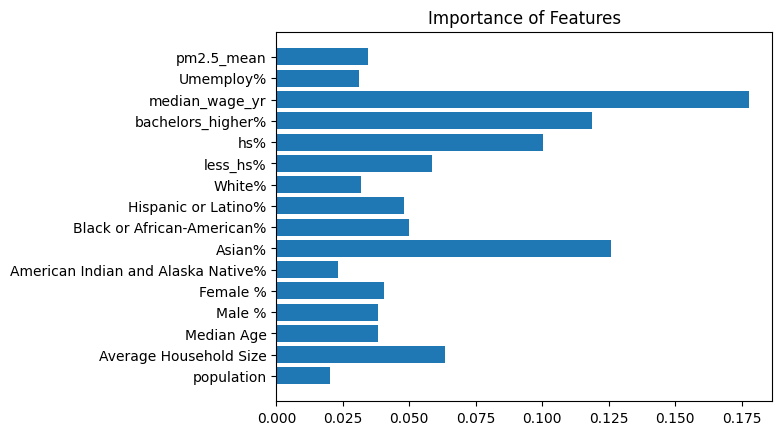

In [23]:
rf_classifier.feature_importances_
plt.barh(features.columns, rf_classifier.feature_importances_)
plt.title('Importance of Features')

We are predicting the probability that a city has a high asthma diagnosis rate. The features we are using are socioeconomic information about the city, percentage of days with good AQI measurements, etc. We are using socioeconomic information because cities might differ in available resources/ infrastructure to prevent the development of asthma. We are also using the percentage of days with good air quality measurements for a city because it has a known medical connection to respiratory health. We are using logistic regression for the GLM requirement and random forest classifier for the non-parametric model requirement because we are predicting a categorical outcome. The assumptions under logistic regression is that the log-odds of the outcome is explained by a linear function of the features.

Based on our random forest classifier, the unemployment rate, median wage, educational attainment looks to be the most important features for predicting high asthma diagnosis rate (minimized cross entropy loss the most). This could be interpreted to be that asthma is preventable w/ economic resources and medical knowledge regardless of the city's rate of bad air quality.

An uncertainty about our model are that the sociodemographic features obtained from the ACS tend to have large margin of errors (high variability) bc/ of the survey process. In addition, our dataset is relatively small which prevents us from extrapolating our findings to larger populations.

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Assuming city_df is your DataFrame
# Drop non-numeric columns and handle missing values
features = city_df.drop(['copd_rate', 'high_copd_rate', 'asthma_rate', 'high_asthma_rate'], axis=1).select_dtypes(include='number').fillna(0)
target = city_df['high_asthma_rate']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create and train the Random Forest Classifier model
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf_classifier = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_rf_classifier = accuracy_score(y_test, y_pred_rf_classifier)
roc_auc_rf_classifier = roc_auc_score(y_test, y_pred_rf_classifier)
report_rf_classifier = classification_report(y_test, y_pred_rf_classifier)

print(f"Accuracy: {accuracy_rf_classifier:.2f}")
print(f"ROC AUC Score: {roc_auc_rf_classifier:.2f}")
print("Classification Report:\n", report_rf_classifier)

Accuracy: 0.97
ROC AUC Score: 0.74
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.98      0.99      0.98        91

    accuracy                           0.97        95
   macro avg       0.82      0.74      0.78        95
weighted avg       0.97      0.97      0.97        95



In [17]:
# Difference in Dataset Sizes Between Asthma and COPD (How does this affect our ability to generalize?)
# Large Variances of Features From ACS data
# Interpretations of Model
# Future Improvements

# increase recall, decrease precision -> set lower threshold for positive predictions
# use ROC_AUC to decide between models - higher ROC_AUC is related to the classification ability of the model